### R. Taylor - HeLICS 2.33 lattice with RF-KO Extraction (26/01/2024)

In [1]:
# For Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize as Norm
import matplotlib as mpl

import numpy as np
import math
from scipy import constants
from scipy.constants import m_p, e, c
import pandas as pd

import os
import json

# Xsuite packages
import xtrack as xt
import xpart as xp
import xobjects as xo

import xplt

#Package used for loading bars
from tqdm.notebook import tqdm

# MADX
from cpymad.madx import Madx

# Consistent figure font sizes
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'axes.titlesize': 18})

/home/rlt5118/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/rlt5118/anaconda3/lib/python3.8/site-packages/xtrack/progress_indicator.py:95: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from xtraction_helpers import plot_two_twiss, MagneticSeptum, ElectrostaticSeptum, BetatronCore

# MADX Setup

In [3]:
madx = Madx()
madx.input('''
title, s='CERN-NIMMS He-ring. Authors: E. Benedetto, R. Taylor, H. Huttunen';

! ==== DRIFTS =====
q_drift        = 1.05;
mb_drift       = 0.2;
mb_quad_drift  = 0.15; // space mb2q + endcoils Q
sx_drift       = 0.5 + 0.7;
ss_drift       =  4.;

! ==== DIPOLE GEOMETRY ====
edge          = 30./180.*pi;
ein1          := edge;  
eout1         := edge;

phi            = 60./180.*pi;
rho            = 2.72;
mb_len        := phi*rho;

! ==== QUADRUPOLE STRENGTHS =====
quad_len       = 0.2;

mb_k1          = -0.11; 
qb_k1          = 1.0860/quad_len;
qf_k1          = 1.989114251411;
qf2_k1         := qf_k1;
qd_k1          = -0.34499331347;

! ==== SEXTUPOLE STRENGTHS ====
sxv_k2         = 1.2;
sx_k2          = 0;! 1.495407498149;

oxv_k3         = 0;

!==== SEPTUM STRENGTHS ====
ese_k          = 0.;
mse_k          = 0.;

lbend         := 4*mb_drift + 2*mb_len + 4*mb_quad_drift + 3*quad_len;
lcell         := lbend+ss_drift; 
circum        := 3*lcell;

voltage=0;
''')

madx.input('''
! ==== DEFINING ELEMENTS ====
mba: sbend, l:=mb_len, angle:=phi, k1:=mb_k1, e1:=ein1,  e2:=eout1;
mbb: sbend, l:=mb_len, angle:=phi, k1:=mb_k1, e1:=eout1, e2:=ein1;

qb:    quadrupole, l:=quad_len, k1:=qb_k1;
qf:    quadrupole, l:=quad_len, k1:=qf_k1;
qf2:    quadrupole, l:=quad_len, k1:=qf2_k1;
qd:    quadrupole, l:=quad_len, k1:=qd_k1;
!qf_ex: quadrupole, l:=quad_len, k1:=qf_k1_ex;

ese_mk: marker;
mse_mk: marker;
ese:    hkicker, kick:= ese_k, l:=0.75;
mse:    hkicker, kick:= mse_k, l:=1.0;

sxv: multipole, knl:={0.,0.,sxv_k2};
sx: multipole, knl:={0.,0.,sx_k2};

cavity: RFCAVITY, L:=1e-6, VOLT:=voltage, lag=0, HARMON = 1, no_cavity_totalpath;
''')

madx.input('''
! ==== DEFINING SEQUENCE ====
he_ring: sequence, refer=center, l:=circum;
    start_He: marker, at := 0.;
    !RF      : cavity, at := 0.01;
    MB1A    : mba,    at :=   mb_drift + mb_len/2;
    QB1     : qb,     at := 2*mb_drift + mb_len   +   quad_len*3/2 + 2*mb_quad_drift;
    SX1A    : sx,    at := 2*mb_drift + mb_len   +   quad_len*5/2 + 3*mb_quad_drift;
    MB1B    : mbb,    at := 3*mb_drift + mb_len/2 + 3*quad_len     + 4*mb_quad_drift + mb_len;
    sxv,              at :=   lbend              + mb_quad_drift/2;
    QD1A    : qd,     at :=   lbend + quad_len/2 + mb_quad_drift;
    QF1A    : qf,     at :=   lbend + quad_len/2 + q_drift;
    ese_mk,           at :=   lbend + quad_len/2 + q_drift + quad_len + 0.25;
    ese,              at :=   lbend + quad_len/2 + q_drift + quad_len + 0.25  +0.75/2;
    QF1B    : qf2,    at :=   lcell + quad_len/2 - q_drift - quad_len;
    QD1B   : qd,    at :=     lcell + quad_len/2 -  mb_quad_drift - quad_len;

    MB2A    : mba,    at :=   mb_len/2  + lcell +   mb_drift;
    QB2     : qb,     at :=   quad_len*3/2 + lcell + 2*mb_drift + mb_len + 2*mb_quad_drift;
    SX2A    : sx,     at :=   quad_len*5/2 + lcell + 2*mb_drift + mb_len + 3*mb_quad_drift;
    MB2B    : mbb,    at :=   mb_len/2  + lcell + 3*mb_drift + mb_len + 4*mb_quad_drift + 3*quad_len;
    QD2A    : qd,     at :=   quad_len/2 + lcell + lbend + mb_quad_drift;    
    QF2A    : qf,     at :=   quad_len/2 + lcell + lbend + q_drift;
    !mse_mk,           at :=   lcell + lbend + q_drift + quad_len + 0.25;
    !
    QF2B    : qf2,    at :=   quad_len/2 + 2*lcell - q_drift - quad_len;
    QD2B    : qd,     at :=   quad_len/2 + 2*lcell - mb_quad_drift - quad_len;

    MB3A    : mba,    at :=   mb_len/2 + 2*lcell +   mb_drift;
    QB3     : qb,     at :=   quad_len*3/2 + 2*lcell + 2*mb_drift + mb_len + 2*mb_quad_drift;
    SX3A    : sx,     at :=   quad_len*5/2 + 2*lcell + 2*mb_drift + mb_len + 3*mb_quad_drift;
    MB3B    : mbb,    at :=   mb_len/2 + 2*lcell + 3*mb_drift + mb_len + 4*mb_quad_drift + 3*quad_len;
    QD3A    : qd,     at :=   quad_len/2 + 2*lcell + lbend + mb_quad_drift;
    QF3A    : qf,     at :=   quad_len/2 + 2*lcell + lbend + q_drift;
    mse_mk,           at :=   2*lcell + lbend + q_drift + quad_len + 0.5;
    mse,              at :=   2*lcell + lbend + q_drift + quad_len + 0.5 + 1.0/2;
    QF3B    : qf2,    at :=   quad_len/2 + 3*lcell - q_drift - quad_len;
    QD3B    : qd,     at :=   quad_len/2 + 3*lcell - mb_quad_drift - quad_len;
    end_He  : marker, at :=   circum;
endsequence;
''')

#madx.input('beam')
mass = 3.727379378
charge = 2.0
madx.input(f'''BEAM;''')#, PARTICLE=ION, MASS={mass}, CHARGE={charge}, PC={1.2994025266713933}, SEQUENCE=he_ring;''')
madx.use('he_ring')

Twiss = madx.twiss().dframe()
summ = madx.table['summ']


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.07.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2021.05.03               +
  + Execution date: 2024.04.25 14:13:29      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
       35.09026404                 -0      0.08812505723         3.36860659 

                q1                dq1            betxmax              dxmax 
       2.400000318       -3.088477865        18.41308442        2.392156492 

             dxrms             xcomax             xcorms                 q2 
       1.100963793                  0                  0        1.149999545 

               dq2            betymax              dymax              dyrms 
      -3.309271084        8.141330747                 -0                  0 

            ycomax             ycorms             deltap 

In [4]:
Qx = 2.329
Qy = 1.075
dQx = 0

madx.input(f'''
use, sequence=he_ring;
MATCH;
GLOBAL, Q1={Qx};
GLOBAL, Q2={Qy};

GLOBAL,dQ1={dQx};

vary, name=qf_k1, step=0.0000001;
vary, name=qd_k1, step=0.0000001;

vary, name=sx_k2, step=0.0000001;

simplex, calls=5000, tolerance=1E-10;
endmatch;''')
Twiss = madx.twiss().dframe()
summ = madx.table['summ']

START MATCHING

number of variables:    3
user given constraints: 1
total constraints:      3

START SIMPLEX:

  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
call:      15   Penalty function =   0.10604221E+02
call:      19   Penalty function =   0.10602527E+02
call:      22   Penalty function =   0.10598539E+02
call:      26   Penalty function =   0.10583394E+02
call:      30   Penalty function =   0.10548878E+02
call:      33   Penalty function =   0.10471013E+02
call:      37   Penalty function =   0.10206920E+02
call:      41   Penalty function =   0.97358274E+01
call:      44   Penalty function =   0.91662050E+01
call:      47   Penalty function =   0.90187521E+01
call:      50   Penalty function =   0.89805097E+01
call:      52   Penalty function =   0.89536914E+01
call:      56   Penalty function =   0.89409688E+01
call:      58   Penalty function =   0.89355142E+01
call: 

## XSuite

In [5]:
# Xsuite Context #############
CPU = xo.ContextCpu() #
GPU = xo.ContextCupy()       # 
ctx = CPU                    #
##############################

In [6]:
xp.HELIUM_MASS_EV = 3727379378
Helium_A = 4

# Details on the beam
T = 45*1E6 * Helium_A     #Kinetic Energy eV
c = constants.c     # m/s, speed of light
E0 = xp.HELIUM_MASS_EV  # 0.93827e9      # eV, proton rest energy
E = T + E0          # Total Energy

gamma = E / E0      # Normalized energy (lorentz)
beta = np.sqrt(1-gamma**-2) # normalised velocity (lorentz)
cp = np.sqrt(E**2 - E0**2)  # eV, particle momentum

# Revolution frequency
rev_freq = (constants.c * beta) / summ['length'][0]

print(f'f_rev = {1E-6*rev_freq:.2f} MHz, beta_rel = {beta:.3f} ')

f_rev = 2.56 MHz, beta_rel = 0.300 


In [7]:
buffer = ctx.new_buffer()
line = xt.Line.from_madx_sequence(madx.sequence['he_ring'], deferred_expressions=True)
line.configure_bend_model(edge='full', core='full')

In [8]:
nturns = int(rev_freq/100)
nparticles = 1E4

# FM Signal

In [9]:
class GenerateFM():
    def __init__(self, nturns):
        self.turn_arr = range(0, nturns)
        
    def random(self):
        kick = [np.random.uniform(-1, 1) for t in self.turn_arr]
        return kick
    
    def sinusoid(self, beam_qx, **kwargs):
        if kwargs:
            qx_init  = kwargs['qxi']
            qx_final = kwargs['qxf']
            sigma = abs(qx_final-qx_init)/2
        else:
            sigma = 0
        qx_dist = np.random.normal(loc=beam_qx, scale=sigma, size=nturns)
        kick = [np.sin(2*np.pi*qx_dist[t] * t) for t in self.turn_arr]
        return kick
        
    def chirp(self, period, qx_init, qx_final):
        freq_dif = (qx_init + (qx_final - qx_init))
        kick = [np.sin(2*np.pi*freq_dif * (t%period) / period * (t%period)) for t in self.turn_arr]
        return np.array(kick)

(0.0, 256.31)

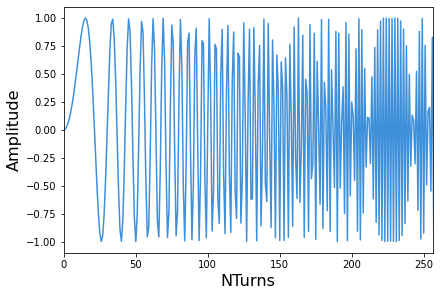

In [10]:
fm_array = GenerateFM(nturns).chirp(period=300, qx_init=0.3289, qx_final=0.3303)

plt.plot(range(nturns), fm_array)
plt.xlabel('NTurns'), plt.ylabel('Amplitude')
plt.xlim(0, nturns/100)

### Method
'rfko' or 'rfko_burst'

In [11]:
method = 'rfko_burst' # 'rfko_burst', 

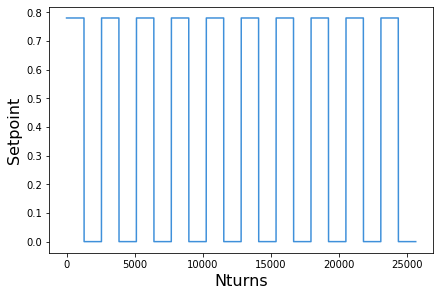

In [12]:
setpoint = nparticles/nturns # Ideal rate of extraction

if method == 'rfko_burst':
    setpoint *= 2
    nturns_burst = int(nturns/20)
    burst_extr_arr = np.concatenate([np.concatenate((setpoint*np.ones(nturns_burst), np.zeros(nturns_burst))) for i in range(int(nturns/2 / nturns_burst))])
    plt.plot(burst_extr_arr)
    plt.xlabel('Nturns'), plt.ylabel('Setpoint')

## PID Controller Parameters

In [13]:
class SimpleSeptum(xt.BeamElement):
    _xofields = {
        'aper_lim':          xo.Float64,
        # Following values are only needed when combined with an RFKOFeedback
        'window_length':     xo.Int64,
        '_num_extracted':    xo.Int64[:],
    }
    needs_cpu = True
    _extra_c_sources = ["""
    /*gpufun*/
    void SimpleSeptum_track_local_particle(SimpleSeptumData el, LocalParticle* part0){
        int64_t window_length = SimpleSeptumData_get_window_length(el);
        int64_t turn      = LocalParticle_get_at_turn(part0) % window_length;
        SimpleSeptumData_set__num_extracted(el, turn, 0);

        //start_per_particle_block (part0->part)
        if(LocalParticle_get_x(part) < SimpleSeptumData_get_aper_lim(el)){
            LocalParticle_set_state(part, -2);
            int64_t turn = LocalParticle_get_at_turn(part) % window_length; 
            int64_t num_extracted = SimpleSeptumData_get__num_extracted(el, turn);
            SimpleSeptumData_set__num_extracted(el, turn, num_extracted+1);
        }
        //end_per_particle_block
}
    """]

    def __init__(self, **kwargs):
        if '_xobject' not in kwargs:
            kwargs.setdefault('window_length', 500)
            kwargs['_num_extracted'] = np.zeros(kwargs['window_length'], dtype=float)
            kwargs.setdefault('aper_lim', ESAno)
        super().__init__(**kwargs)

In [14]:
class RFKOFeedback(xt.BeamElement):
    '''
    Kp       : float - Coefficient of P controller. Recommend to be on the order of window_size / nturns * 1E-7
    Ki       : float - Coefficient of I controller. Recommended to be Kp/2
    Kd       : float - Coefficient of D controller. Recommended to be Kp/4
    t_burst
    setpoint : float - gradient that defines error, to tend towards ideal rate of extraction
    limit    : float - initial kick amplitude [rad], will update each turn
    minlim   : float - minimum kick amplitude [rad], const
    maxlim   : float - maximum kick amplitude [rad], const
    I        : float - initially zero, updates with error
    pickup   : SimpleSeptum xtrack element - contains extracted particles numparticles array
    _prev_err: float - holding memory of previous error for D controller
    '''
    _xofields = {
        'kick_fm'  : xo.Float64[:],
        'Kp'       : xo.Float64,
        'Ki'       : xo.Float64,
        'Kd'       : xo.Float64,
        't_burst'  : xo.Int64,
        'setpoint' : xo.Float64[:],
        'limit'    : xo.Float64,
        'minlim'   : xo.Float64,
        'maxlim'   : xo.Float64, 
        'I'        : xo.Float64,
        'waist_t'  : xo.Int64,
        'pickup'   : xo.Ref[SimpleSeptum],
        '_prev_err': xo.Float64,
    }

    needs_cpu = True

    _extra_c_sources = ["""
    #define SEPTUM_WITH_FEEDBACK
    #define MAX(a,b) ((a) > (b) ? (a) : (b))
    #define MIN(a,b) ((a) < (b) ? (a) : (b))


    void RFKOFeedback_track_local_particle(RFKOFeedbackData el, LocalParticle* part0){
        SimpleSeptumData pick = RFKOFeedbackData_getp_pickup(el);
        int64_t window_length      = SimpleSeptumData_get_window_length(pick);
        int64_t t_burst            = RFKOFeedbackData_get_t_burst(el);

        // Get the number of particles extracted at the septum, averaged over the last window_length turns.
        ArrNInt64 num_extracted_arr = SimpleSeptumData_getp__num_extracted(pick);
        int64_t current_turn      = LocalParticle_get_at_turn(&part0[0]);
        
        // ##### Frequency Modulation ######
        double kick_fm = RFKOFeedbackData_get_kick_fm(el, current_turn);
        
        double dparticles_dt      = 0;
        for (int i=0; i<window_length; ++i){
            dparticles_dt += ArrNInt64_get(num_extracted_arr, i);
        }
        dparticles_dt /= window_length;

        // Get other stable variables
        double setpoint = RFKOFeedbackData_get_setpoint(el, current_turn);

        // Get other dynamic variables
        double prev_err = RFKOFeedbackData_get__prev_err(el);
        double error    = setpoint - dparticles_dt;

        if ((int)(current_turn/t_burst) % 2) {
            double Kp      = RFKOFeedbackData_get_Kp(el);
            double Ki      = RFKOFeedbackData_get_Ki(el);
            double Kd      = RFKOFeedbackData_get_Kd(el);
            double P       = Kp * error;
            double I       = RFKOFeedbackData_get_I(el) + Ki*error*window_length;
            double D       = Kd * prev_err;
            double minlim  = RFKOFeedbackData_get_minlim(el);
            double maxlim  = RFKOFeedbackData_get_maxlim(el);
            double prevlim = RFKOFeedbackData_get_limit(el);
            
            double limit = prevlim;
            kick_fm = 0;
            RFKOFeedbackData_set_limit(el, limit);
            
        }
        else {
            if (current_turn % window_length == 0){
                double Kp      = RFKOFeedbackData_get_Kp(el);
                double Ki      = RFKOFeedbackData_get_Ki(el);
                double Kd      = RFKOFeedbackData_get_Kd(el);
                double P       = Kp * error;
                double I       = RFKOFeedbackData_get_I(el) + Ki*error*window_length;
                double D       = Kd * prev_err;
                double minlim  = RFKOFeedbackData_get_minlim(el);
                double maxlim  = RFKOFeedbackData_get_maxlim(el);
                double prevlim = RFKOFeedbackData_get_limit(el);
                double waist_t = RFKOFeedbackData_get_waist_t(el);

                double limit_waist  = MIN(MAX(prevlim - P - I - D, minlim), maxlim);
                double limit_final  = MIN(MAX(prevlim + P + I + D, minlim), maxlim);

                double limit = limit_final * (current_turn > waist_t) + limit_waist * (current_turn <= waist_t);

                RFKOFeedbackData_set_I(el, I);
                RFKOFeedbackData_set_limit(el, limit);
                RFKOFeedbackData_set__prev_err(el, error);
            }
        }
        double limit   = RFKOFeedbackData_get_limit(el);

        // ##### Frequency Modulation ######
        double curr_kick = limit * kick_fm;

        FILE* f = fopen("ParticleTracks/RFKO/turn_info.txt", "a");
        if (f != NULL) {
            fprintf(f, "[%ld,%le,%le,%le,%le];", current_turn, dparticles_dt, curr_kick, limit, error);
        }
        fclose(f);

        //start_per_particle_block (part0->part)
            LocalParticle_set_px(part, LocalParticle_get_px(part) + curr_kick);
        //end_per_particle_block
    }
    """]

    def __init__(self, **kwargs):
        if '_xobject' not in kwargs:
            #kwargs['kick_fm'] = GenerateFM(nturns).sinusoid(tune, qxi=0.3285, qxf=0.3295)
            kwargs['kick_fm'] = GenerateFM(nturns).chirp(period=300, qx_init=0.3289, qx_final=0.3303)
            kwargs.setdefault('Kp', Kp)
            kwargs.setdefault('t_burst', nturns_burst)
            kwargs.setdefault('Kd', Kd)
            kwargs.setdefault('Ki', Ki)
            kwargs.setdefault('setpoint', setpoint)
            kwargs.setdefault('limit', limit)
            kwargs.setdefault('minlim', minlim)
            kwargs.setdefault('maxlim', maxlim)
            kwargs.setdefault('waist_t', 0)
            kwargs.setdefault('_prev_err', 0)
            kwargs['I'] = 0
            if 'pickup' not in kwargs:
                raise ValueError("Need to provide a Septum as a pickup!")
        super().__init__(**kwargs)

In [15]:
### Variables for RF-KO Optimisation ##
window_length = 300 # The controller is defined by the number of particles extracted in this timeframe

Kp = 1.5E-5
Kd = 1.5E-6
Ki = 5E-9 #Kd/2

if method == 'rfko_burst':
    setpoint = burst_extr_arr  
    
limit = 5E-7   # Initial amplitude
minlim = 1E-8  # Minimal amplitude
maxlim = 1E-2  # Maximum amplitude (to prevent beam blowup)
waist_t = 0    # To reduce kick before increasing it

### Septum Geometry

In [17]:
ESAno = -75E-3 # -55E-3 # -35E-3
ESCat = ESAno - 21E-3
ESWid = 0.2E-3

MSWid = 20E-3
MSAno = 85E-3 #60E-3
MSCat = MSAno + MSWid + 84E-3

In [18]:
SimpleSepta_test = SimpleSeptum(aper_lim = ESAno, window_length=window_length, _buffer=buffer) #xt.LimitRect(max_x=ESAno) 
line.insert_element(element=SimpleSepta_test, name='es1', at_s=Twiss.s['ese_mk']-0.0001)

In [19]:
rfko_controller = RFKOFeedback(pickup=SimpleSepta_test, _buffer=buffer, limit=limit, Kp=Kp, Ki=Ki, Kd=Kd, waist_t=waist_t,setpoint=setpoint)
line.insert_element(element=rfko_controller, name='rfko', index=1)

### Generate Particles - Select from initial file

In [20]:
line.build_tracker(_buffer=buffer)
xp.HELIUM_MASS_EV = 3727379378
particles = xp.Particles(mass0=xp.HELIUM_MASS_EV, q0=2, p0c=cp, nparticles=nparticles, _buffer=buffer)
line.particle_ref = particles

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [21]:
with open(f"11012024_1000_100000_chroma0_init_particles.json", 'r') as fid:
    particles  = xp.Particles.from_dict(json.load(fid), _buffer=buffer)   
particles = particles.filter(particles.particle_id < nparticles)

(Text(0.5, 0, 'X [m]'), Text(0, 0.5, 'Y [m]'))

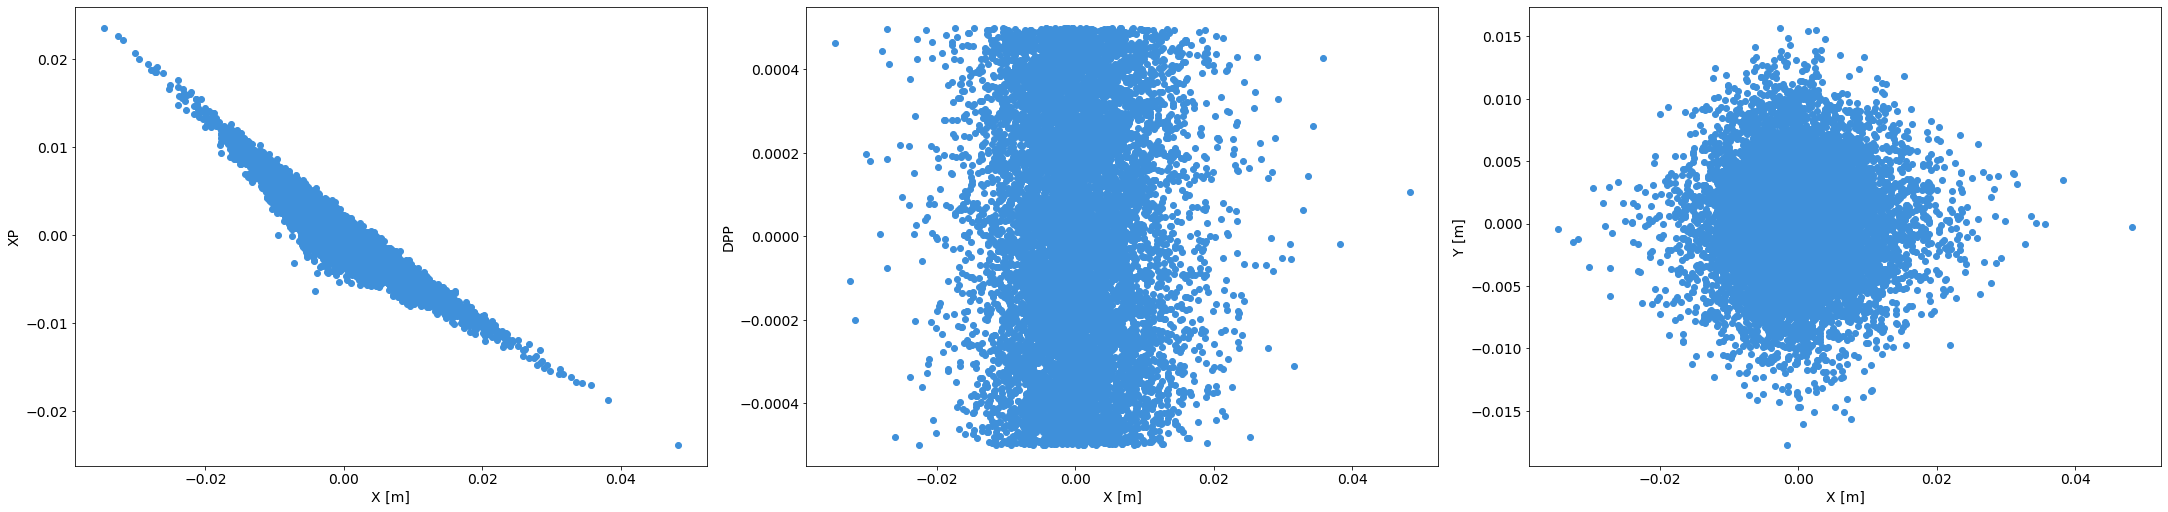

In [22]:
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 14})
figure = plt.figure(figsize=(30, 7))
ax1 = figure.add_subplot(1,3,1)
ax2 = figure.add_subplot(1,3,2)
ax3 = figure.add_subplot(1,3,3)

ax1.plot(particles.x, particles.px,'o')
ax1.set_xlabel('X [m]'), ax1.set_ylabel('XP')

ax2.plot(particles.x, particles.delta,'o')
ax2.set_xlabel('X [m]'), ax2.set_ylabel('DPP')

ax3.plot(particles.x, particles.y,'o')
ax3.set_xlabel('X [m]'), ax3.set_ylabel('Y [m]')

# Track!

In [ ]:
sx_k2 = 1.2
line.vars['sxv_k2'] = sx_k2

#os.remove('turn_info.txt')
for iturn in tqdm(range(nturns)):
    line.track(particles)